In [1]:
# 运行环境
# Python3.7
# PyTorch 0.2，安装参考https://pytorch.org/get-started/locally/

In [2]:
# MNIST数据集准备
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import nn
# batch_size超参，根据硬件配置相应大小
batch_size = 32

trans_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# MNIST数据集每张图片是灰度图片，大小为28x28
trainset = MNIST('data', train=True, download=True, transform=trans_img)
testset = MNIST('data', train=False, download=True, transform=trans_img)
train_loader = DataLoader(trainset, batch_size=batch_size, 
                          shuffle=True, num_workers=1)
test_loader = DataLoader(testset, batch_size=batch_size, 
                          shuffle=True, num_workers=1)# 运行环境
# Python2.7
# PyTorch 0.2，安装参考https://pytorch.org/get-started/locally/# 运行环境
# Python2.7
# PyTorch 0.2，安装参考https://pytorch.org/get-started/locally/

In [3]:
import matplotlib.pyplot as plt

plt.ion()
cnt = 0
for (img_batch, label) in train_loader:
    cnt += 1
    if cnt > 10:
        break
    fig, ax = plt.subplots(
        nrows=4,
        ncols=8,
        sharex=True,
        sharey=True, )
    ax = ax.flatten()
    for i in range(32):
        img = img_batch[i].numpy().reshape(28, 28)
        ax[i].imshow(img, cmap='Greys', interpolation='nearest')

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.show()
    plt.close()
plt.ioff()

<Figure size 640x480 with 32 Axes>

<Figure size 640x480 with 32 Axes>

<Figure size 640x480 with 32 Axes>

<Figure size 640x480 with 32 Axes>

<Figure size 640x480 with 32 Axes>

<Figure size 640x480 with 32 Axes>

<Figure size 640x480 with 32 Axes>

<Figure size 640x480 with 32 Axes>

<Figure size 640x480 with 32 Axes>

<Figure size 640x480 with 32 Axes>

In [4]:
# Recurrent Network 模型构建
class Rnn(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_layer, n_class):
        super(Rnn, self).__init__()
        self.n_layer = n_layer
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layer, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, n_class)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.classifier(out)
        return out

In [6]:
from torch import optim
from torch.autograd import Variable
import warnings
warnings.filterwarnings("ignore",category=UserWarning)
# Recurrent Network 模型训练代码
model = Rnn(28, 128, 2, 10).cuda()  # 图片大小是28x28，输入维度为28，隐藏单元维度为128，LSTM层数为2，类别数为10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epochs = 10
train_losses=[]
test_losses=[]
for epoch in range(epochs):
    running_loss, running_acc = 0., 0.
    for (img, label) in train_loader:
        img = Variable(img.squeeze(1)).cuda()
        label = Variable(label).cuda()
        
        optimizer.zero_grad()
        out = model(img)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predict = torch.max(out, 1)
        correct_num = (predict == label).sum()
        running_acc += correct_num.item() 

    running_loss /= len(trainset)
    running_acc /= len(trainset)
    
    with torch.no_grad():
        test_loss, test_acc = 0., 0.
        for images, labels in test_loader:
            images = Variable(images.squeeze(1)).cuda()
            labels = Variable(labels).cuda()
            output = model(images)
            loss = criterion(output, labels)

            test_loss += loss.item()
            _, predict = torch.max(output, 1)
            correct_num = (predict == labels).sum()
            test_acc += correct_num.item()
    
    test_loss /=len(testset)
    test_acc /=len(testset)
    
    train_losses.append(running_loss)
    test_losses.append(test_loss)
    print("Epoch: {}/{}.. ".format(epoch+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Training Accuracy: {:.3f} %".format(100*running_acc),
          "Test Loss: {:.3f}.. ".format(test_losses[-1]),
          "Test Accuracy: {:.3f} %".format(100*test_acc))
# 保存模型
torch.save(model, 'rnn.pth.tar')

Epoch: 1/10..  Training Loss: 0.280..  Training Accuracy: 90.830 % Test Loss: 0.082..  Test Accuracy: 97.560 %
[1/10] Loss: 0.27972, Acc: 90.83
Epoch: 2/10..  Training Loss: 0.078..  Training Accuracy: 97.695 % Test Loss: 0.060..  Test Accuracy: 98.240 %
[2/10] Loss: 0.07829, Acc: 97.69
Epoch: 3/10..  Training Loss: 0.056..  Training Accuracy: 98.362 % Test Loss: 0.054..  Test Accuracy: 98.500 %
[3/10] Loss: 0.05616, Acc: 98.36
Epoch: 4/10..  Training Loss: 0.044..  Training Accuracy: 98.683 % Test Loss: 0.046..  Test Accuracy: 98.660 %
[4/10] Loss: 0.04381, Acc: 98.68
Epoch: 5/10..  Training Loss: 0.035..  Training Accuracy: 98.910 % Test Loss: 0.052..  Test Accuracy: 98.490 %
[5/10] Loss: 0.03468, Acc: 98.91
Epoch: 6/10..  Training Loss: 0.032..  Training Accuracy: 99.028 % Test Loss: 0.045..  Test Accuracy: 98.600 %
[6/10] Loss: 0.03169, Acc: 99.03
Epoch: 7/10..  Training Loss: 0.026..  Training Accuracy: 99.188 % Test Loss: 0.045..  Test Accuracy: 98.690 %
[7/10] Loss: 0.02555, Acc

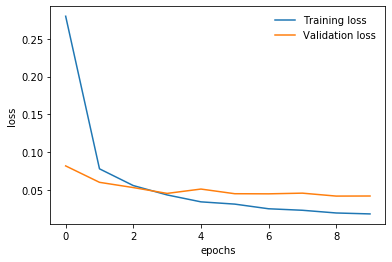

In [7]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses,label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(frameon=False)

In [9]:
model = torch.load('rnn.pth.tar')
print('testing rnn model')
testloss, testacc = 0., 0.
for (img, label) in test_loader:
    img = img.squeeze(1)
    img = Variable(img).cuda()
    label = Variable(label).cuda()    
    out = model(img)
    loss = criterion(out, label)
    testloss += loss.item()
    _, predict = torch.max(out, 1)
    correct_num = (predict == label).sum()
    testacc += correct_num.item() 
        
testloss /= len(testset)
testacc /= len(testset)
print('rnn model, Test: Loss: %.5f, Acc: %.2f' %
      (testloss, 100 * testacc))

testing rnn model
rnn model, Test: Loss: 0.04239, Acc: 98.77
